In [ ]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler  # For feature scaling
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # Performance metrics
from tensorflow.keras.models import Sequential  # For building neural network models
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Dense  # Different RNN architectures
from tensorflow.keras.callbacks import EarlyStopping  # To prevent overfitting
import warnings

# Suppress warnings to keep output clean and focused
warnings.filterwarnings("ignore")

In [ ]:

# STEP 1: DATA EXPLORATION AND VISUALIZATION

# Load the dataset from CSV

data = pd.read_csv('Google_Stock_Price_Train.csv')

# Data Cleaning: Remove commas from 'Close' column and convert to numeric

data['Close'] = data['Close'].str.replace(',', '').astype(float)

# Convert 'Date' to datetime and set as index for time-series analysis

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

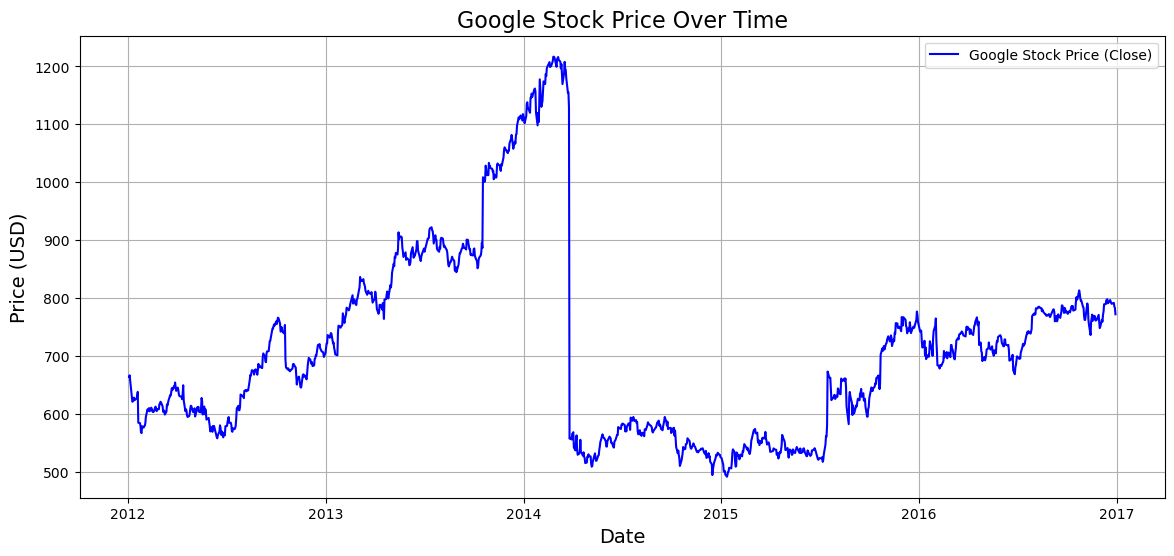

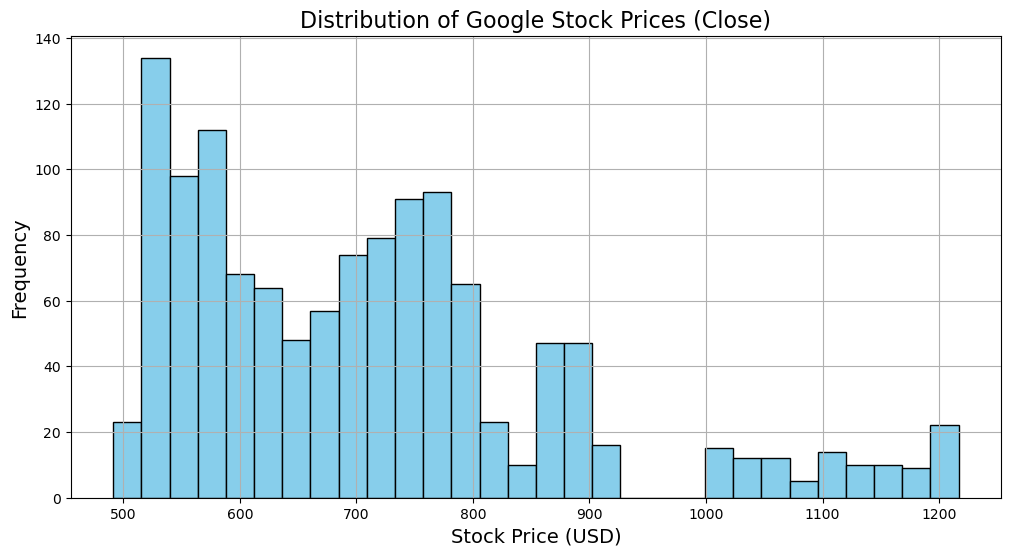

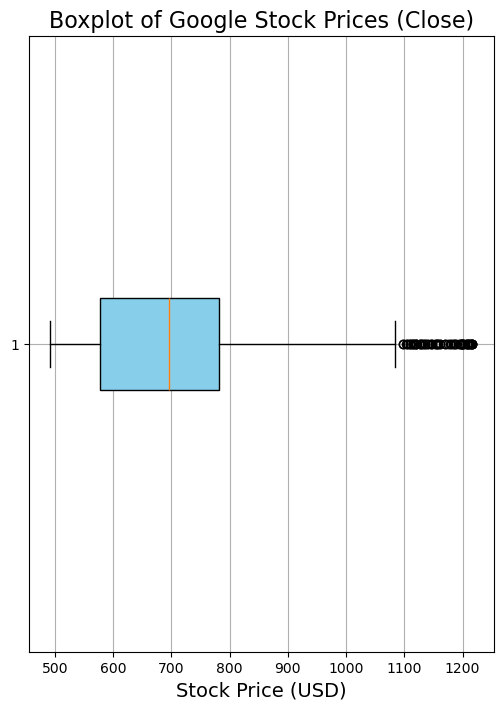

In [ ]:
# VISUALIZATION 1: Stock Price Trend

plt.figure(figsize=(14, 6))
plt.plot(data['Close'], label='Google Stock Price (Close)', color='blue')
plt.title('Google Stock Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# VISUALIZATION 2: Price Distribution Histogram

plt.figure(figsize=(12, 6))
plt.hist(data['Close'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Google Stock Prices (Close)', fontsize=16)
plt.xlabel('Stock Price (USD)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()

# VISUALIZATION 3: Price Boxplot

plt.figure(figsize=(6, 8))
plt.boxplot(data['Close'], vert=False, patch_artist=True, boxprops=dict(facecolor='skyblue'))
plt.title('Boxplot of Google Stock Prices (Close)', fontsize=16)
plt.xlabel('Stock Price (USD)', fontsize=14)
plt.grid(True)
plt.show()

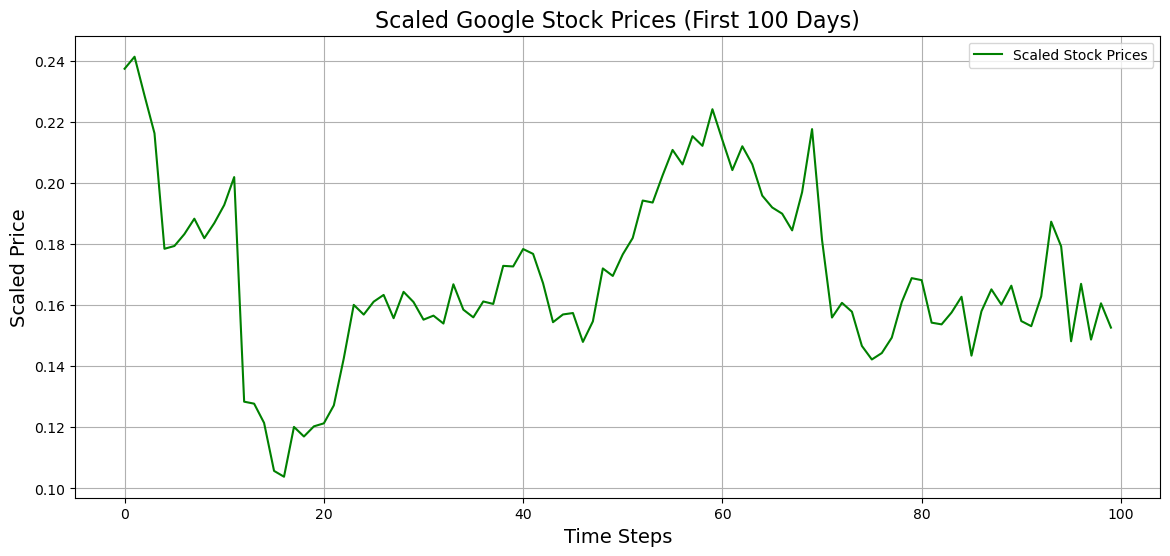

In [4]:
# STEP 2: DATA PREPROCESSING
# Objective: Prepare data for sequential modeling
# Key tasks: Normalization, sequence creation, train-test split

# Normalize data using MinMaxScaler
# Scales data to [0,1] range, crucial for neural network training
# Prevents dominance of larger magnitude features
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data[['Close']])

# Function to create input sequences for time-series prediction
# Converts time series into supervised learning problem
# Allows model to learn from past N days to predict next day's price
def create_sequences(data, lookback=30):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])  # Input: last 'lookback' days
        y.append(data[i, 0])            # Target: next day's price
    return np.array(X), np.array(y)

# Experimental Design: Multiple Sequence Lengths
# Investigate how different historical window sizes affect prediction
# Tests model's performance under various input configurations
sequence_lengths = [7, 14, 30, 60]  # Different lookback periods
datasets = {}

# Create datasets for each sequence length
# Splits data into training, validation, and test sets
for lookback in sequence_lengths:
    X, y = create_sequences(data_scaled, lookback)
    train_size = int(0.8 * len(X))
    val_size = int(0.1 * len(X))
    datasets[lookback] = {
        'X_train': X[:train_size].reshape((train_size, lookback, 1)),
        'y_train': y[:train_size],
        'X_val': X[train_size:train_size+val_size].reshape((val_size, lookback, 1)),
        'y_val': y[train_size:train_size+val_size],
        'X_test': X[train_size+val_size:].reshape((len(X) - train_size - val_size, lookback, 1)),
        'y_test': y[train_size+val_size:]
    }

# Visualization of Scaled Data
# Shows how normalization transforms original data
plt.figure(figsize=(14, 6))
plt.plot(data_scaled[:100], label='Scaled Stock Prices', color='green')
plt.title('Scaled Google Stock Prices (First 100 Days)', fontsize=16)
plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('Scaled Price', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

Training RNN with lookback = 7...
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1075 - val_loss: 8.8903e-04
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0014 - val_loss: 3.3355e-04
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0010 - val_loss: 3.6528e-04
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.9233e-04 - val_loss: 4.3587e-04
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0012 - val_loss: 3.2614e-04
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1497e-04 - val_loss: 3.1161e-04
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0010 - val_loss: 4.3048e-04
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7226e-04 - val_loss: 3.5779e-04
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0024 - val_loss: 3.5950e-04
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8302e-04 - val_loss: 2.8909e-04
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.2535e-04

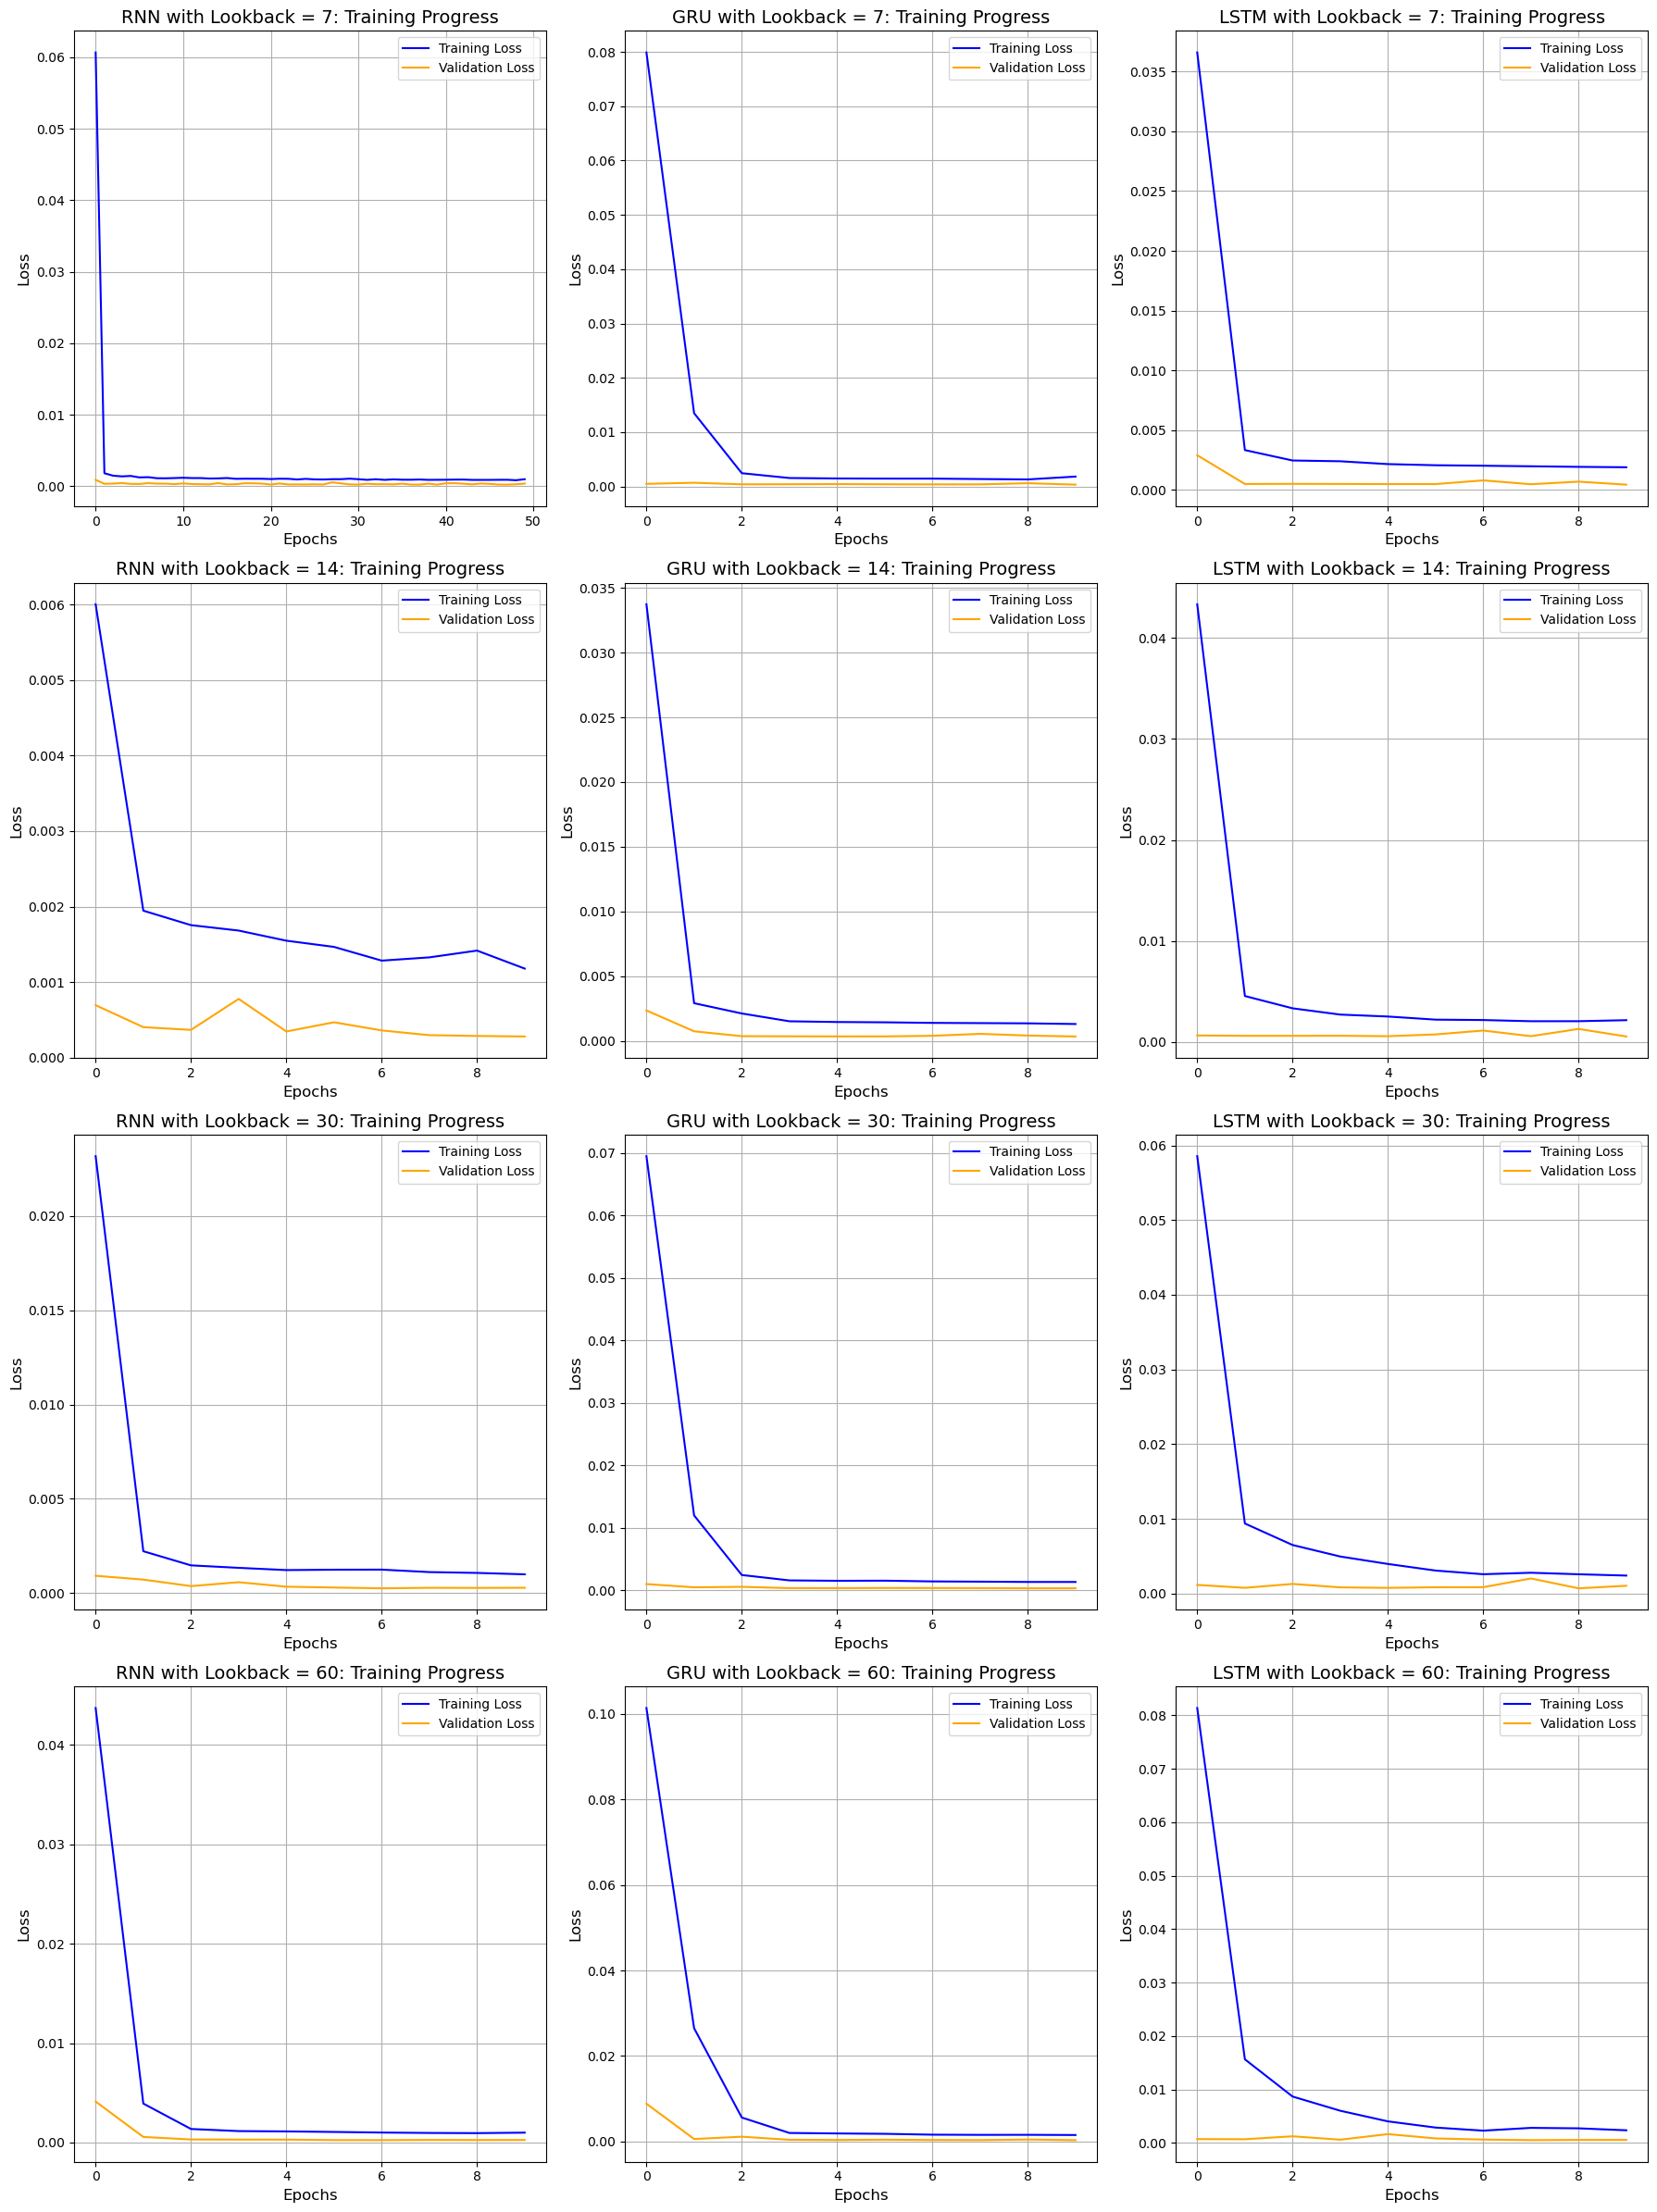

In [5]:
# STEP 3: BUILD AND TRAIN MODELS
# Objective: Implement different RNN architectures
# Experiment with RNN, GRU, and LSTM networks

# Function to build RNN-based models
# Allows flexible creation of different neural network architectures
def build_model(model_type, units=50, input_shape=(30, 1)):
    model = Sequential()
    if model_type == 'RNN':
        model.add(SimpleRNN(units, activation='relu', input_shape=input_shape))
    elif model_type == 'GRU':
        model.add(GRU(units, activation='relu', input_shape=input_shape))
    elif model_type == 'LSTM':
        model.add(LSTM(units, activation='relu', input_shape=input_shape))
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Early stopping to prevent overfitting
# Monitors validation loss and stops training if no improvement
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Function to train and validate models
# Handles model training with early stopping and validation
def train_model(model_type, dataset):
    model = build_model(model_type, input_shape=(dataset['X_train'].shape[1], 1))
    history = model.fit(
        dataset['X_train'], dataset['y_train'],
        epochs=50, batch_size=32,
        validation_data=(dataset['X_val'], dataset['y_val']),
        callbacks=[early_stopping],
        verbose=1
    )
    return model, history

# Train models for each sequence length
# Comprehensive experimental setup to test different configurations
results = {}

for lookback, dataset in datasets.items():
    results[lookback] = {}
    for model_type in ['RNN', 'GRU', 'LSTM']:
        print(f"Training {model_type} with lookback = {lookback}...")
        model, history = train_model(model_type, dataset)
        results[lookback][model_type] = {
            'model': model,
            'history': history
        }

# Create grid of training progress plots
# Comprehensive visualization of training and validation loss
fig, axes = plt.subplots(len(datasets), 3, figsize=(18, 6 * len(datasets)))

for i, (lookback, models) in enumerate(results.items()):
    for j, (model_type, model_info) in enumerate(models.items()):
        history = model_info['history']
        axes[i, j].plot(history.history['loss'], label='Training Loss', color='blue')
        axes[i, j].plot(history.history['val_loss'], label='Validation Loss', color='orange')
        axes[i, j].set_title(f'{model_type} with Lookback = {lookback}: Training Progress', fontsize=14)
        axes[i, j].set_xlabel('Epochs', fontsize=12)
        axes[i, j].set_ylabel('Loss', fontsize=12)
        axes[i, j].legend()
        axes[i, j].grid(True)

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()

In [6]:
# STEP 4: MODEL EVALUATION
# Objective: Assess model performance using multiple metrics
# Compare different RNN architectures and sequence lengths

# Function to evaluate models on test data
# Computes standard regression metrics and rescales predictions
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    predictions_rescaled = scaler.inverse_transform(predictions)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
    r2 = r2_score(y_test_rescaled, predictions_rescaled)
    mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
    return rmse, r2, mae, y_test_rescaled, predictions_rescaled

# Evaluate all models
# Systematic assessment across different configurations
evaluation_results = {}

for lookback, models in results.items():
    evaluation_results[lookback] = {}
    for model_type, model_info in models.items():
        metrics = evaluate_model(model_info['model'], datasets[lookback]['X_test'], datasets[lookback]['y_test'])
        evaluation_results[lookback][model_type] = metrics


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x17fdff100> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━

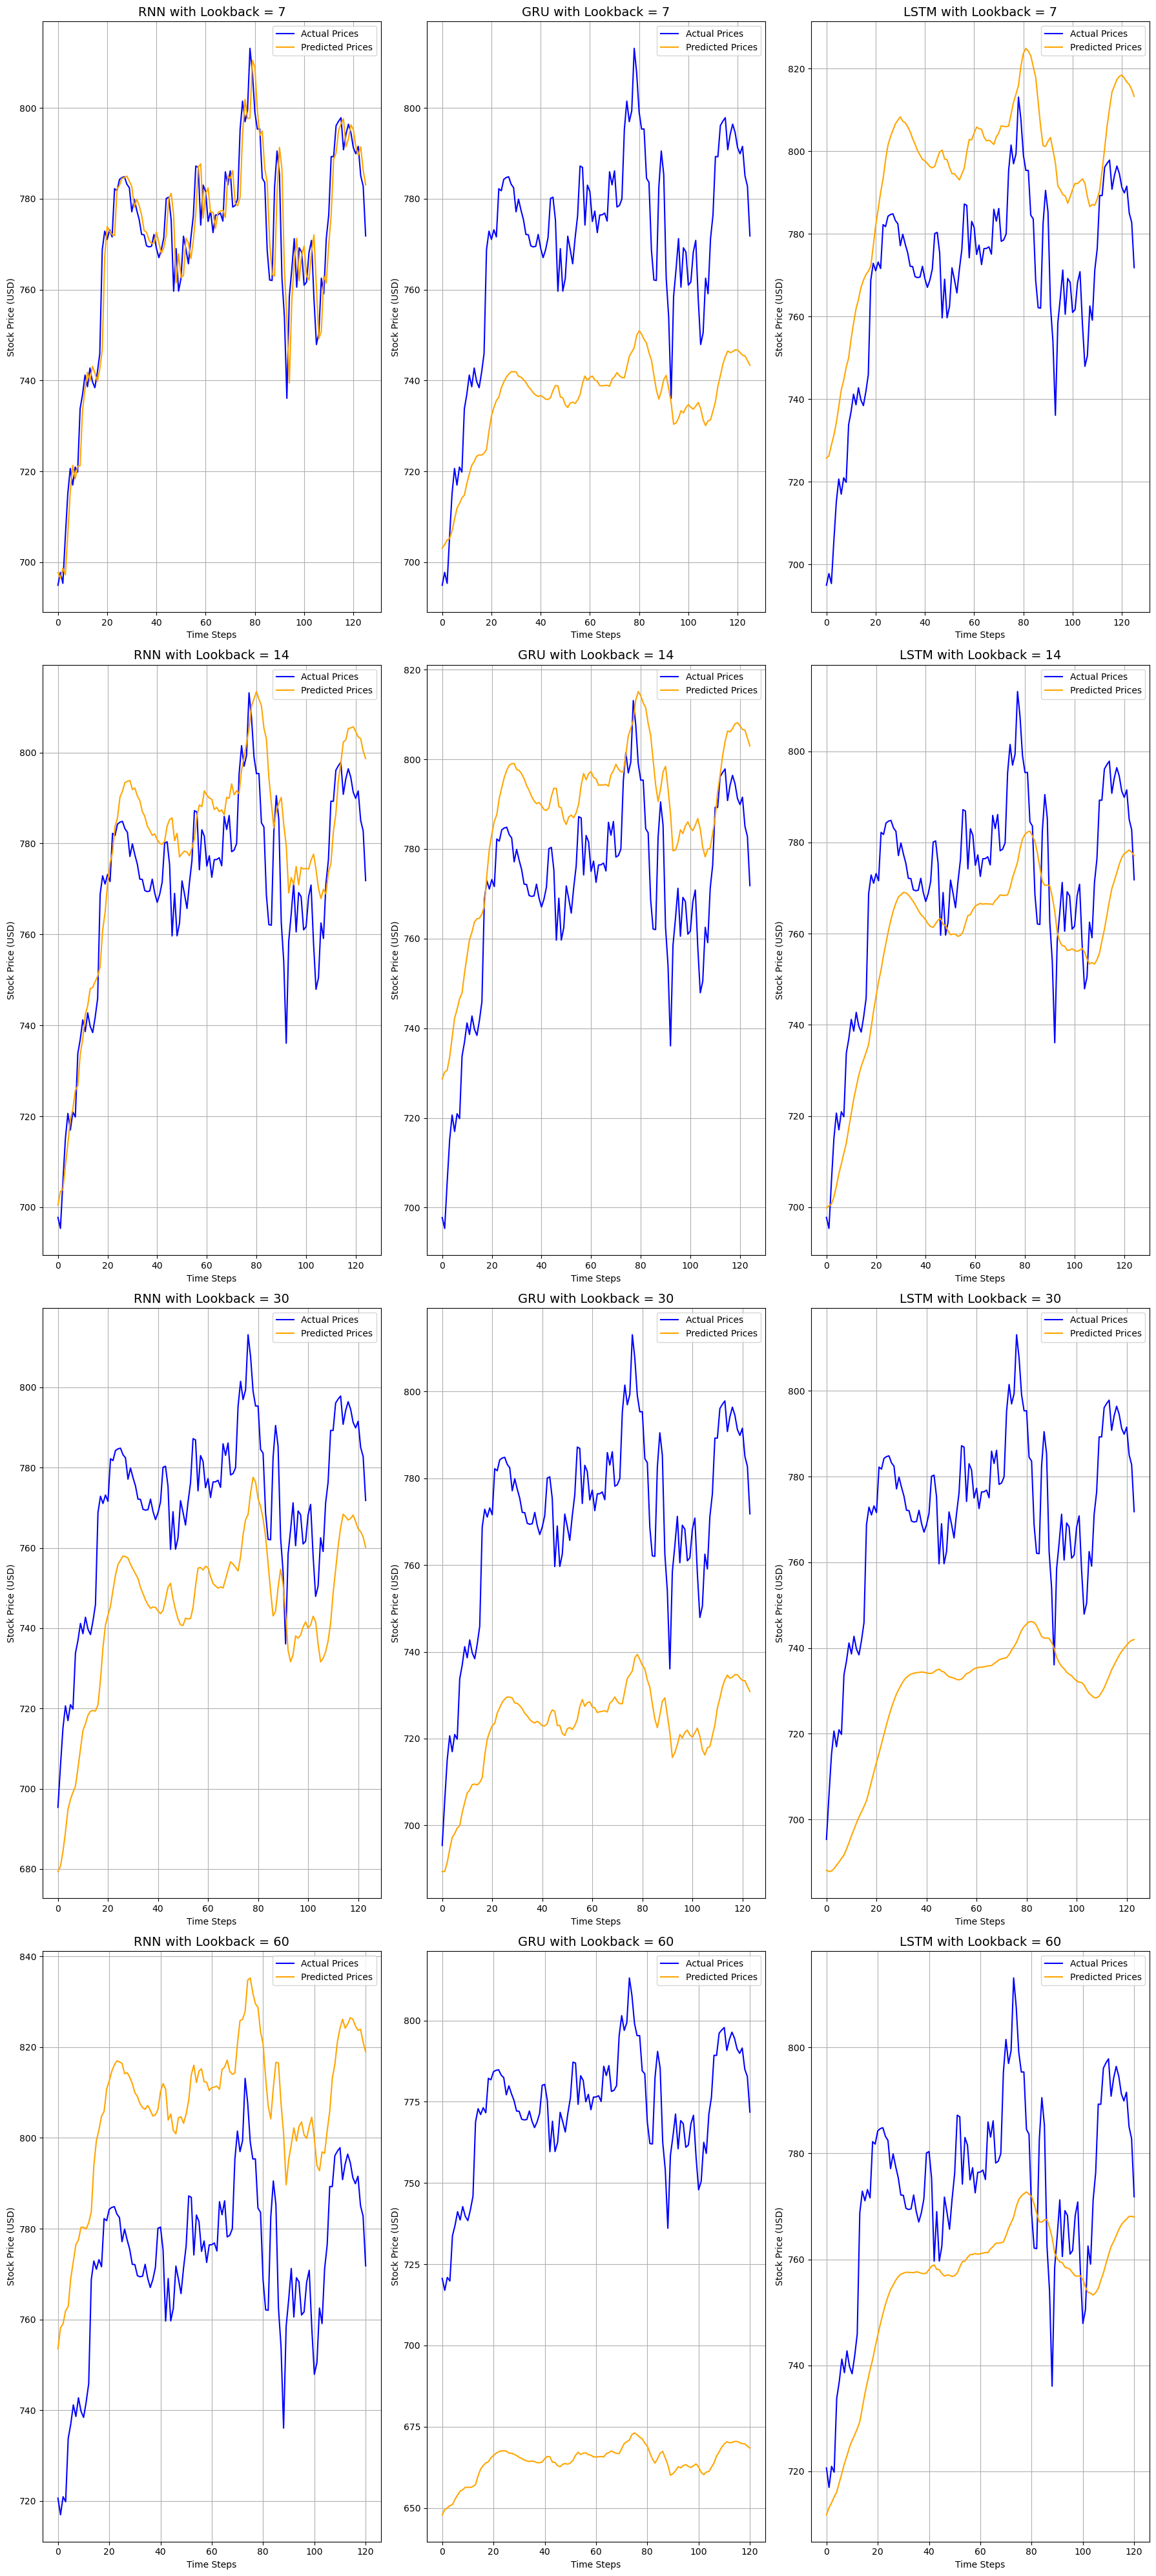

Lookback = 7 Results:
RNN - RMSE: 7.3852, R²: 0.8962, MAE: 5.4283
GRU - RMSE: 37.0486, R²: -1.6127, MAE: 34.6329
LSTM - RMSE: 26.5227, R²: -0.3390, MAE: 24.5246
Lookback = 14 Results:
RNN - RMSE: 13.1978, R²: 0.6405, MAE: 10.5808
GRU - RMSE: 19.8705, R²: 0.1850, MAE: 17.6803
LSTM - RMSE: 16.7964, R²: 0.4177, MAE: 14.2473
Lookback = 30 Results:
RNN - RMSE: 27.9642, R²: -0.7551, MAE: 26.4605
GRU - RMSE: 49.3775, R²: -4.4722, MAE: 47.7722
LSTM - RMSE: 44.4683, R²: -3.4382, MAE: 42.2636
Lookback = 60 Results:
RNN - RMSE: 35.2695, R²: -2.5975, MAE: 34.2777
GRU - RMSE: 109.0328, R²: -33.3812, MAE: 108.0761
LSTM - RMSE: 21.9234, R²: -0.3900, MAE: 19.0030


In [7]:

# STEP 5: RESULTS VISUALIZATION
# Objective: Comprehensive visual comparison of model predictions

# Create grid of actual vs predicted price plots
# Allows side-by-side comparison of different model performances
fig, axes = plt.subplots(len(sequence_lengths), 3, figsize=(18, 10 * len(sequence_lengths)))
for i, lookback in enumerate(sequence_lengths):
    for j, model_type in enumerate(['RNN', 'GRU', 'LSTM']):
        metrics = evaluation_results[lookback][model_type]
        actual, predicted = metrics[3], metrics[4]
        axes[i, j].plot(actual, label='Actual Prices', color='blue')
        axes[i, j].plot(predicted, label='Predicted Prices', color='orange')
        axes[i, j].set_title(f'{model_type} with Lookback = {lookback}', fontsize=14)
        axes[i, j].set_xlabel('Time Steps')
        axes[i, j].set_ylabel('Stock Price (USD)')
        axes[i, j].legend()
        axes[i, j].grid(True)

plt.tight_layout()
plt.show()

# Compare and print model performance metrics
# Provides textual summary of model performances
for lookback, models in evaluation_results.items():
    print(f"Lookback = {lookback} Results:")
    for model_type, metrics in models.items():
        print(f"{model_type} - RMSE: {metrics[0]:.4f}, R²: {metrics[1]:.4f}, MAE: {metrics[2]:.4f}")